In [9]:
import glob
from natsort import natsorted

s_dict = {'table_start': 0, 'hand_start': 1, 'off_start': 2}
fi_dict = {'nothing': 0, 'pasta': 1, 'rice': 2, 'water': 3}
fu_dict = {'zero': 0, 'fifty': 1, 'ninety': 2}
b_dict = {'regular': 0, 'textured': 1}
l_dict = {'light0': 0, 'light1': 1}
c_dict = {'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4}
obj_id_dict = {1: 'red cup', 2: 'small white cup',3:'small transparent cup',4:'green glass',5:'wine glass',
              6:'champagne flute glass', 7:'cereal box',8:'biscuit box',9:'tea box'} 

valid_dict = {'s': list(s_dict.keys()), 
              'fi': list(fi_dict.keys()),
              'fu': list(fu_dict.keys()),
              'b': list(b_dict.keys()),
              'l': list(l_dict.keys()),
              'c': list(c_dict.keys()),
              'obj_id': list(obj_id_dict.keys()),
             }

def retrieve_data(obj_id, s, fi, fu, b, l, c=[]):
    if ((fi == 'nothing' and (fu =='fifty' or fu =='ninety')) or (fi == 'pasta' and fu == 'zero') or (fi == 'rice' and fu=='zero') or (fi=='water' and fu=='zero')): 
        #print('error')
        return -1
    for i in range(1,len(c),1):
        if c[i] not in valid_dict['c']:
            return -1
    if  (obj_id not in obj_id_dict) or (s not in valid_dict['s']) or (fi not in valid_dict['fi']) or (fu not in valid_dict['fu']) or (b not in valid_dict['b']) or (l not in valid_dict['l']) :
        return -1
    
    _obj_id = obj_id
    _s_id = s_dict[s]
    _fi_id = fi_dict[fi]
    _fu_id = fu_dict[fu]
    _b_id = b_dict[b]
    _l_id = l_dict[l]
    _c_id = []
    
    for i in range(0,len(c),1):
        _c_id.append(c_dict[c[i]])
    if(len(c)==0):
        _c_id = [1,2,3,4]
        
    input_string = 's'+str(_s_id)+'_fi'+str(_fi_id)+'_fu'+str(_fu_id)+'_b'+str(_b_id)+'_l'+str(_l_id)
    
    audio_path = "./*Dataset/"+str(_obj_id)+"/audio/"+input_string+"*"
    audio_list = glob.glob(audio_path)[0]
    
    calib_list = []
    for i in range(0,len(_c_id),1):
        calib_path = "./*Dataset/"+str(_obj_id)+"/calib/"+input_string+'_c'+str(_c_id[i])+'*'
        calib_list.append(glob.glob(calib_path)[0])
    
    depth_list = []
    for i in range(0,len(_c_id),1):
        depth_path = "./*Dataset/"+str(_obj_id)+"/depth/"+input_string+'/c'+str(_c_id[i])+'/*'
        depth_list.append(natsorted(glob.glob(depth_path), key=lambda y: y.lower()))
        
    imu_path = "./*Dataset/"+str(_obj_id)+"/imu/"+input_string+"*"
    imu_list = tuple(glob.glob(imu_path))
    
    
    ir_list=[]
    for i in range(0,len(_c_id),1):
        ir_path = "./*Dataset/"+str(_obj_id)+"/ir/"+input_string+'_c'+str(_c_id[i])+'*'
        ir_list.append(glob.glob(ir_path))
    
    
    rgb_list = []
    for i in range(0,len(_c_id),1):
        rgb_path = "./*Dataset/"+str(_obj_id)+"/rgb/"+input_string+'_c'+str(_c_id[i])+'*'
        rgb_list.append(glob.glob(rgb_path)[0])
    
    
    output_dict = {'audio': audio_list,'calib':calib_list,'depth':depth_list,'imu':imu_list,'ir':ir_list,'rgb':rgb_list}
    return output_dict

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def computeObjectBoundingBox(depth_img_path, debug=False):
    # Define height limit to search, since bottom area is always a table
    HEIGHT_LIMIT = 600
    # Minimum area of the contours to be considered
    MIN_CONTOUR_AREA = 15000
    # In percentage (of bounding box)
    BBOX_EXPANSION = 1.05

    # Load image as uint16
    cv_img = cv2.imread(depth_img_path, -1)[:HEIGHT_LIMIT]

    if debug:
        # Show image
        plt.imshow(cv_img)
        plt.title("Original Depth Image")
        plt.show()

    # Find stats of image
    #mean = np.mean(cv_img)
    #std = np.std(cv_img)

    # Define distance threshold
    DIST_THRESHOLD = 700
    #DIST_THRESHOLD = mean - std

    # Filter pixels by distance threshold
    filter1 = np.where(cv_img < DIST_THRESHOLD, cv_img, 0)

    # Extract contours
    # Convert to unsigned 8-bit
    filter1_8u = ((filter1 / filter1.max()) * 255).astype(np.uint8)
    # Apply closing operation, try to retrieve some of the "missing" regions
    kernel = np.ones((15, 15), np.uint8)
    filter1_8u = cv2.morphologyEx(filter1_8u, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(filter1_8u, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        if debug:
            print("Couldn't find any contours")
            
        return cv_img, None

    if debug:
        viz_img = np.dstack([filter1_8u.copy(), filter1_8u.copy(), filter1_8u.copy()])

    # Iterate over contours, find the largest one
    #candidates = []
    bestContour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > MIN_CONTOUR_AREA and bestContour is None:
            bestContour = contour
        elif area > MIN_CONTOUR_AREA and bestContour is not None:
            # Use contour to find mask
            curr_cnt_mask = np.zeros(cv_img.shape, np.uint8)
            cv2.drawContours(curr_cnt_mask, [contour], 0, 255, -1)
            
            best_cnt_mask = np.zeros(cv_img.shape, np.uint8)
            cv2.drawContours(best_cnt_mask, [bestContour], 0, 255, -1)
            
            best_cnt_mean = cv2.mean(cv_img, mask=best_cnt_mask)
            curr_cnt_mean = cv2.mean(cv_img, mask=curr_cnt_mask)
            
            if curr_cnt_mean[0] < best_cnt_mean[0]:
                bestContour = contour
            
            if debug:
                plt.imshow(curr_cnt_mask, cmap='gray')
                plt.title("Current contour mask")
                plt.show()
                plt.imshow(best_cnt_mask, cmap='gray')
                plt.title("best contour mask")
                plt.show()            

    # Given the largest contour, find the bounding box
    if bestContour is not None:
        #print("Found object contour!")

        # If we found our object contour, find the bounding box
        x, y , w, h = cv2.boundingRect(bestContour)

    else:
        if debug:
            print("Couldn't determine object contour")
        return cv_img, None
    
    # Expand the bounding box a bit
    inc_w_h = int((w * BBOX_EXPANSION - w) / 2)
    inc_h_h = int((h * BBOX_EXPANSION - h) / 2)
    
    topx = x - inc_w_h
    topy = y - inc_h_h
    botx = x + w + inc_w_h
    boty = y + h + inc_h_h
    
    # Make sure values stay within range
    if topx < 0:
        topx = 0
    if topy < 0:
        topy = 0
    if botx > cv_img.shape[1]:
        botx = cv_img.shape[1]
    if boty > cv_img.shape[0]:
        boty = cv_img.shape[0]
    
    pt1 = (topx, topy)
    pt2 = (botx, boty)

    if debug:
        cv2.rectangle(viz_img, pt1, pt2, (255, 0, 0), 3)    

        cv2.drawContours(viz_img, contours, -1, (0, 255, 0), 2)

        plt.imshow(filter1)
        plt.title(f"Cropped to `DIST_THRESHOLD={DIST_THRESHOLD}` pixels")
        plt.show()

        plt.imshow(filter1_8u, cmap='gray')
        plt.title(f"Unsigned 8 image")
        plt.show()

        plt.imshow(viz_img, cmap='gray')
        plt.title(f"Viz image")
        plt.show()

    return cv_img, (filter1, pt1, pt2)
    
def findBestFrameROI(depth_imgs, search_max=30):
    _index = -1
    if len(depth_imgs) < search_max:
        search_n = len(depth_imgs) - 1
    else:
        search_n = search_max
        
    for _ in range(search_n):
        depth_img, ret = computeObjectBoundingBox(depth_imgs[_index], debug=False)
        
        #plt.imshow(depth_img)
        #plt.show()
        
        if ret != None:
            filter1, (topx, topy), (botx, boty) = ret

            roi = filter1[topy:boty, topx:botx]
            
            return roi

            #plt.imshow(filter1)
            #plt.show()

            #plt.imshow(roi)
            #plt.show()
            #print('#'*80)

        _index += -1
        
    #print("No roi for this sample.")
    return None
                     
# The capacity of the containers in mL
ANNOTATION = {1: 520.0, # Red cup
              2: 185.0, # Small white cup
              3: 202.0, # Small transparent cup
              4: 296.0, # Green glass
              5: 363.0, # Wine glass
              6: 128.0, # Champagne flute
              7: 3209.397, # Cereal box
              8: 1239.84, # Biscuits box
              9: 471.6} # Tea box

ANNOTATION_MEAN = 734.981888888889
ANNOTATION_STD = 929.7103190574344

IMG_WIDTH = 1280
IMG_HEIGHT = 720
MAX_VAL = 700 # Anything larger than this distance in the images, is discarded

total = 0
failed = 0
failed_samples = []

data = []
labels = []
for obj_id in range(1, 10):
    print(f"Extracting data from object id: `{obj_id}`")
    for sit in s_dict.keys():
        for fi in fi_dict.keys():
            for fu in fu_dict.keys():
                for b in b_dict.keys():
                    for l in l_dict.keys():
                        try:
                            sample = retrieve_data(obj_id, s=sit, fi=fi, fu=fu, b=b, l=l)
                        except Exception as e:
                            #print(f"Failed...: {(obj_id, sit, fi, fu, b, l)}")
                            pass
                        if sample != -1:
                            ret = findBestFrameROI(sample['depth'][2])
                            total += 1
                            if ret is None:
                                print(f"Failed for {sample['depth'][2][-1]}")
                                failed += 1
                                failed_samples.append((sit, fi, fu, b, l))
                            else:
                                # Add sample to dataset
                                roi_h, roi_w = ret.shape
                                
                                # Normalize ROI by max val
                                data.append((np.divide(ret, MAX_VAL), roi_h/IMG_HEIGHT, roi_w/IMG_WIDTH))

                                # Get label data
                                labels.append(ANNOTATION[obj_id]/4000)

print(len(data), len(labels))
print(f"Out of {total} samples, {failed} failed to find object ROI")          

Extracting data from object id: `1`
Extracting data from object id: `2`
Extracting data from object id: `3`
Failed for ./Dataset/3/depth/s0_fi3_fu2_b0_l1/c3/0307.png
Extracting data from object id: `4`
Extracting data from object id: `5`


<ipython-input-2-9dfd42fb2c6d>:35: RuntimeWarning: invalid value encountered in true_divide
  filter1_8u = ((filter1 / filter1.max()) * 255).astype(np.uint8)


Failed for ./Dataset/5/depth/s2_fi1_fu1_b0_l0/c3/0206.png
Failed for ./Dataset/5/depth/s2_fi1_fu2_b0_l0/c3/0335.png
Extracting data from object id: `6`
Extracting data from object id: `7`
Failed for ./Dataset/7/depth/s2_fi0_fu0_b1_l0/c3/0098.png
Failed for ./Dataset/7/depth/s2_fi1_fu1_b1_l0/c3/0100.png
Failed for ./Dataset/7/depth/s2_fi1_fu2_b1_l0/c3/0105.png
Failed for ./Dataset/7/depth/s2_fi2_fu1_b0_l0/c3/0139.png
Extracting data from object id: `8`
Failed for ./Dataset/8/depth/s2_fi1_fu1_b0_l0/c3/0140.png
Failed for ./Dataset/8/depth/s2_fi1_fu2_b0_l0/c3/0143.png
Failed for ./Dataset/8/depth/s2_fi2_fu1_b0_l0/c3/0134.png
Extracting data from object id: `9`
Failed for ./Dataset/9/depth/s2_fi1_fu1_b0_l0/c3/0132.png
Failed for ./Dataset/9/depth/s2_fi2_fu2_b0_l0/c3/0131.png
672 672
Out of 684 samples, 12 failed to find object ROI


[0.032      0.04625    0.0505     0.074      0.09075    0.1179
 0.13       0.30996    0.80234925] [84 84 83 84 82 58 84 57 56]


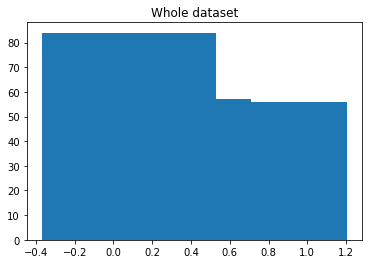

[0.032      0.04625    0.0505     0.074      0.09075    0.1179
 0.13       0.30996    0.80234925] [77 72 76 72 70 50 66 44 44]


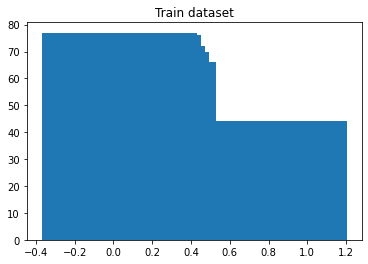

[0.032      0.04625    0.0505     0.074      0.09075    0.1179
 0.13       0.30996    0.80234925] [ 7 12  7 12 12  8 18 13 12]


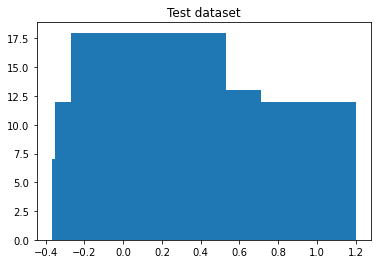

In [10]:
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
import torch

NET_SIZE = (112, 112)

# Analyze class distribution and 
_classes, counts = np.unique(labels, return_counts=True)
print(_classes, counts)
plt.bar(_classes, counts)
plt.title("Whole dataset")
plt.show()

# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                   test_size=0.15)

_classes, counts = np.unique(y_train, return_counts=True)
n_train_samples = len(y_train)
print(_classes, counts)
plt.bar(_classes, counts)
plt.title("Train dataset")
plt.show()

_classes, counts = np.unique(y_test, return_counts=True)
print(_classes, counts)
plt.bar(_classes, counts)
plt.title("Test dataset")
plt.show()

class VolumeDataset(Dataset):
    def __init__(self, x, y):
        self.images = []
        self.rois_size = []
        
        for _x in x:
            self.images.append(cv2.resize(_x[0], (112, 112)))
            self.rois_size.append((_x[1], _x[2]))
        
        self.y_volume = y
        
        assert len(self.images) == len(self.rois_size)
        assert len(self.images) == len(self.y_volume)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return (torch.Tensor(self.images[idx]).unsqueeze(0), torch.Tensor(self.rois_size[idx])), torch.Tensor([self.y_volume[idx]])
    
train_dataset = VolumeDataset(X_train, y_train)
test_dataset = VolumeDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,
                          num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                          num_workers=0)

#for (img, roi_info), volume in test_loader:
#    print(img.shape)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
    
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size=(3, 3),
                               padding=1,
                               stride=1)
        
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=(3, 3),
                               padding=1,
                               stride=1)
        
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=64,
                               kernel_size=(3, 3),
                               padding=1,
                               stride=1)
        
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=(3, 3),
                               padding=1,
                               stride=1)
        
        self.bn4 = nn.BatchNorm2d(128)
        
        self.linear1 = nn.Linear(7*7*128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        
        self.linear2 = nn.Linear(64, 6)
        self.linear3 = nn.Linear(8, 1) # 6 + 2 roi_info features
        
        self.pool = nn.MaxPool2d((2, 2))
        
    def forward(self, img, roi_info):
        o1 = F.relu(self.conv1(img))
        o1 = self.pool(self.bn1(o1))
        #print(o1.shape)
        
        o2 = F.relu(self.conv2(o1))
        o2 = self.pool(self.bn2(o2))
        #print(o2.shape)
        
        o3 = F.relu(self.conv3(o2))
        o3 = self.pool(self.bn3(o3))
        #print(o3.shape)
        
        o4 = F.relu(self.conv4(o3))
        o4 = self.pool(self.bn4(o4))
        #print(o4.shape)

        # Keep batch dim and flatten
        conv_out = o4.view(-1, 7*7*128)
        
        l1 = F.relu(self.linear1(conv_out))
        l1 = self.bn5(l1)
        
        l2 = F.relu(self.linear2(l1))
        
        # Concat roi_info along with the processed conv features
        concat = torch.cat((l2, roi_info), 1)
        #print(l1[0])

        # Pay attention to the activation here
        out = self.linear3(concat)
        
        return out

INTERVAL = 15
    
model = ConvNet()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.00025)
criterion = nn.MSELoss()

for epoch in range(200):
    print(f"Epoch {epoch+1}")
    running_loss = 0.0
    model.train()
    for i_batch, batch in enumerate(train_loader):
        (x_img, x_roi_info), y_volume = batch[0], batch[1].cuda()
        x_img = x_img.cuda()
        x_roi_info = x_roi_info.cuda()
        
        assert len(x_img) == len(y_volume)

        optimizer.zero_grad()
        
        pred_y_volume = model(x_img, x_roi_info)
        
        loss = criterion(pred_y_volume, y_volume)
        #print(pred_y_volume.shape, y_volume.shape)
        #print(pred_y_volume[0], y_volume[0])
        
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        if i_batch % INTERVAL == INTERVAL-1:
            running_loss += running_loss
            print(f"[{epoch+1}, {i_batch+1}]: MSE Loss: {running_loss/INTERVAL:.4f}")
            running_loss = 0.0
            
    if epoch % 10 == 9:
        test_loss = 0.0
        total_samples = 0
        with torch.no_grad():
            model.eval()
            for batch in test_loader:
                (x_img, x_roi_info), y_volume = batch[0], batch[1].cuda()
                x_img = x_img.cuda()
                x_roi_info = x_roi_info.cuda()
                
                loss = criterion(pred_y_volume, y_volume)
                test_loss += loss.item()
                total_samples += 1
                
            test_loss = test_loss / total_samples
            
            print(f"Test Loss: {test_loss:.5f}")
            print("#"*40)

Epoch 1
[1, 15]: MSE Loss: 0.2125
[1, 30]: MSE Loss: 0.1393
[1, 45]: MSE Loss: 0.0915
[1, 60]: MSE Loss: 0.0770
Epoch 2
[2, 15]: MSE Loss: 0.0627
[2, 30]: MSE Loss: 0.0664
[2, 45]: MSE Loss: 0.0704
[2, 60]: MSE Loss: 0.0658
Epoch 3
[3, 15]: MSE Loss: 0.0513
[3, 30]: MSE Loss: 0.0551
[3, 45]: MSE Loss: 0.0577
[3, 60]: MSE Loss: 0.0709
Epoch 4
[4, 15]: MSE Loss: 0.0686
[4, 30]: MSE Loss: 0.0375
[4, 45]: MSE Loss: 0.0431
[4, 60]: MSE Loss: 0.0581
Epoch 5
[5, 15]: MSE Loss: 0.0282
[5, 30]: MSE Loss: 0.0434
[5, 45]: MSE Loss: 0.0394
[5, 60]: MSE Loss: 0.0292
Epoch 6
[6, 15]: MSE Loss: 0.0287
[6, 30]: MSE Loss: 0.0243
[6, 45]: MSE Loss: 0.0304
[6, 60]: MSE Loss: 0.0187
Epoch 7
[7, 15]: MSE Loss: 0.0164
[7, 30]: MSE Loss: 0.0197
[7, 45]: MSE Loss: 0.0211
[7, 60]: MSE Loss: 0.0280
Epoch 8
[8, 15]: MSE Loss: 0.0265
[8, 30]: MSE Loss: 0.0202
[8, 45]: MSE Loss: 0.0316
[8, 60]: MSE Loss: 0.0232
Epoch 9
[9, 15]: MSE Loss: 0.0163
[9, 30]: MSE Loss: 0.0145
[9, 45]: MSE Loss: 0.0164
[9, 60]: MSE Loss:

/home/ntnuerc/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.07305
########################################
Epoch 11
[11, 15]: MSE Loss: 0.0188
[11, 30]: MSE Loss: 0.0231
[11, 45]: MSE Loss: 0.0230
[11, 60]: MSE Loss: 0.0254
Epoch 12
[12, 15]: MSE Loss: 0.0290
[12, 30]: MSE Loss: 0.0323
[12, 45]: MSE Loss: 0.0261
[12, 60]: MSE Loss: 0.0275
Epoch 13
[13, 15]: MSE Loss: 0.0206
[13, 30]: MSE Loss: 0.0177
[13, 45]: MSE Loss: 0.0186
[13, 60]: MSE Loss: 0.0216
Epoch 14
[14, 15]: MSE Loss: 0.0148
[14, 30]: MSE Loss: 0.0147
[14, 45]: MSE Loss: 0.0258
[14, 60]: MSE Loss: 0.0155
Epoch 15
[15, 15]: MSE Loss: 0.0103
[15, 30]: MSE Loss: 0.0111
[15, 45]: MSE Loss: 0.0177
[15, 60]: MSE Loss: 0.0179
Epoch 16
[16, 15]: MSE Loss: 0.0114
[16, 30]: MSE Loss: 0.0114
[16, 45]: MSE Loss: 0.0191
[16, 60]: MSE Loss: 0.0159
Epoch 17
[17, 15]: MSE Loss: 0.0160
[17, 30]: MSE Loss: 0.0191
[17, 45]: MSE Loss: 0.0105
[17, 60]: MSE Loss: 0.0081
Epoch 18
[18, 15]: MSE Loss: 0.0167
[18, 30]: MSE Loss: 0.0103
[18, 45]: MSE Loss: 0.0170
[18, 60]: MSE Loss: 0.0103
Epoc

[77, 60]: MSE Loss: 0.0066
Epoch 78
[78, 15]: MSE Loss: 0.0059
[78, 30]: MSE Loss: 0.0042
[78, 45]: MSE Loss: 0.0034
[78, 60]: MSE Loss: 0.0033
Epoch 79
[79, 15]: MSE Loss: 0.0043
[79, 30]: MSE Loss: 0.0034
[79, 45]: MSE Loss: 0.0093
[79, 60]: MSE Loss: 0.0032
Epoch 80
[80, 15]: MSE Loss: 0.0055
[80, 30]: MSE Loss: 0.0044
[80, 45]: MSE Loss: 0.0039
[80, 60]: MSE Loss: 0.0110
Test Loss: 0.06331
########################################
Epoch 81
[81, 15]: MSE Loss: 0.0114
[81, 30]: MSE Loss: 0.0058
[81, 45]: MSE Loss: 0.0064
[81, 60]: MSE Loss: 0.0050
Epoch 82
[82, 15]: MSE Loss: 0.0043
[82, 30]: MSE Loss: 0.0042
[82, 45]: MSE Loss: 0.0042
[82, 60]: MSE Loss: 0.0058
Epoch 83
[83, 15]: MSE Loss: 0.0053
[83, 30]: MSE Loss: 0.0033
[83, 45]: MSE Loss: 0.0051
[83, 60]: MSE Loss: 0.0041
Epoch 84
[84, 15]: MSE Loss: 0.0053
[84, 30]: MSE Loss: 0.0033
[84, 45]: MSE Loss: 0.0075
[84, 60]: MSE Loss: 0.0048
Epoch 85
[85, 15]: MSE Loss: 0.0037
[85, 30]: MSE Loss: 0.0044
[85, 45]: MSE Loss: 0.0095
[85,

[143, 15]: MSE Loss: 0.0035
[143, 30]: MSE Loss: 0.0033
[143, 45]: MSE Loss: 0.0037
[143, 60]: MSE Loss: 0.0039
Epoch 144
[144, 15]: MSE Loss: 0.0048
[144, 30]: MSE Loss: 0.0124
[144, 45]: MSE Loss: 0.0179
[144, 60]: MSE Loss: 0.0093
Epoch 145
[145, 15]: MSE Loss: 0.0052
[145, 30]: MSE Loss: 0.0071
[145, 45]: MSE Loss: 0.0057
[145, 60]: MSE Loss: 0.0082
Epoch 146
[146, 15]: MSE Loss: 0.0036
[146, 30]: MSE Loss: 0.0053
[146, 45]: MSE Loss: 0.0053
[146, 60]: MSE Loss: 0.0036
Epoch 147
[147, 15]: MSE Loss: 0.0045
[147, 30]: MSE Loss: 0.0031
[147, 45]: MSE Loss: 0.0037
[147, 60]: MSE Loss: 0.0041
Epoch 148
[148, 15]: MSE Loss: 0.0075
[148, 30]: MSE Loss: 0.0076
[148, 45]: MSE Loss: 0.0059
[148, 60]: MSE Loss: 0.0036
Epoch 149
[149, 15]: MSE Loss: 0.0032
[149, 30]: MSE Loss: 0.0029
[149, 45]: MSE Loss: 0.0041
[149, 60]: MSE Loss: 0.0033
Epoch 150
[150, 15]: MSE Loss: 0.0045
[150, 30]: MSE Loss: 0.0032
[150, 45]: MSE Loss: 0.0033
[150, 60]: MSE Loss: 0.0037
Test Loss: 0.20500
###############

In [5]:
def getModelPrediction(model, depth_frames):
    roi = findBestFrameROI(depth_frames)
    
    if roi is not None:
        h, w = roi.shape
        h = h / IMG_HEIGHT
        w = w / IMG_WIDTH
        
        # Normalize and resize roi
        roi = np.divide(roi, MAX_VAL)
        roi = cv2.resize(roi, NET_SIZE)
        
        # Convert everything to tensors
        tensor_roi = torch.Tensor(roi).unsqueeze(0)
        tensor_roi = tensor_roi.unsqueeze(0).cuda()
        tensor_roi_info = torch.Tensor([h, w]).unsqueeze(0).cuda()

        # Feed to model and get prediction
        with torch.no_grad():
            pred = model(tensor_roi, tensor_roi_info)
            return pred.item()*4000 #* ANNOTATION_STD) + ANNOTATION_MEAN
    else:
        print("Couldnt find roi")
        return None

In [6]:
import pandas as pd
def generatesubmission(feature,data_list):
    df = pd.read_csv('submissions/submissionfile.csv',index_col=0)
    df[feature] = data_list
    df.to_csv('./submissions/submissionfile-record.csv')

In [7]:
model.eval()
preds = []
for j in range(10,12):
    for i in range(84):
        i_str = str(i)
        _str = '0' * (4 - len(i_str)) + i_str
        sample_frames = natsorted(glob.glob(f'Dataset/{j}/depth/{_str}/c3/*.png'))

        pred = getModelPrediction(model, sample_frames)
        if pred is not None:
            preds.append(pred)
        else:
            preds.append(-1)
for i in range(60):
    i_str = str(i)
    _str = '0' * (4 - len(i_str)) + i_str
    sample_frames = natsorted(glob.glob(f'Dataset/12/depth/{_str}/c3/*.png'))

    pred = getModelPrediction(model, sample_frames)
    if pred is not None:
        preds.append(pred)
    else:
        preds.append(-1)

Couldnt find roi
Couldnt find roi


<ipython-input-2-9dfd42fb2c6d>:35: RuntimeWarning: invalid value encountered in true_divide
  filter1_8u = ((filter1 / filter1.max()) * 255).astype(np.uint8)


Couldnt find roi
Couldnt find roi
Couldnt find roi
Couldnt find roi
Couldnt find roi
Couldnt find roi
Couldnt find roi
Couldnt find roi
Couldnt find roi
Couldnt find roi
Couldnt find roi


In [8]:
generatesubmission('Container Capacity',preds)